# Shazam

Have you ever wondered what is happening under the hood of the popular music search tool? How can a track be indentified among the millions of other tracks by a short sample in just a few seconds? Obviously, this is not a mere brute force. Today we will remove the veil and find out what kind of magic happens there by implementing the algorithm on our own.

Refer to the [original article](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) for implementation details.

## Installing needed libraries

In [2]:
# please read https://github.com/librosa/librosa
# you may need ffmpeg to be installed
# !pip install librosa --user

In [1]:
# !conda install -c conda-forge ffmpeg
import warnings
warnings.filterwarnings('ignore')

## Reading and resampling audio tracks database

In [2]:
# https://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

audios = ['mp3/ACDC.mp3', 'mp3/iamthemorning.mp3', 'mp3/Little Big.mp3']
request_audio = 'mp3/request.mp3'

def read_and_resample(path, sample_rate):
    # read and resample to 22KHz
    y, sr = librosa.load(path, sr=sample_rate)    
    print(f"{path} length is {y.shape[0] / sample_rate / 60.:.2f} min")
    return y

dataset = {}
sample_rate = 22050
# reading all audios
for path in audios:
    dataset[path] = read_and_resample(path, sample_rate)

# reading request audio
request_data = read_and_resample(request_audio, sample_rate)

mp3/ACDC.mp3 length is 4.88 min
mp3/iamthemorning.mp3 length is 3.83 min
mp3/Little Big.mp3 length is 2.68 min
mp3/request.mp3 length is 0.17 min


## Visualizing example spectrogram

We will use [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) to emphasize perception rather than amplitude.

Spectrogram shape: (128, 12599)


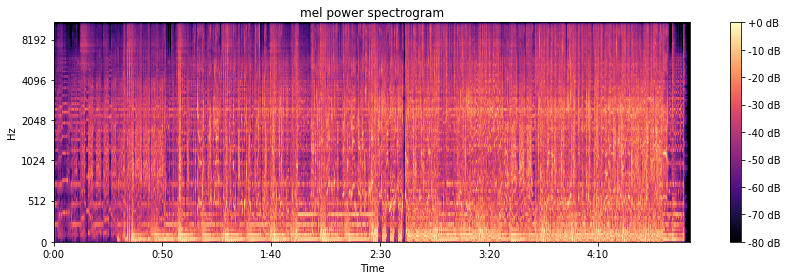

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

y = dataset['mp3/ACDC.mp3']

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)

print(f"Spectrogram shape: {S.shape}")

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## Forming constellations

Time resolution: 0.02321972427354941
mp3/ACDC.mp3


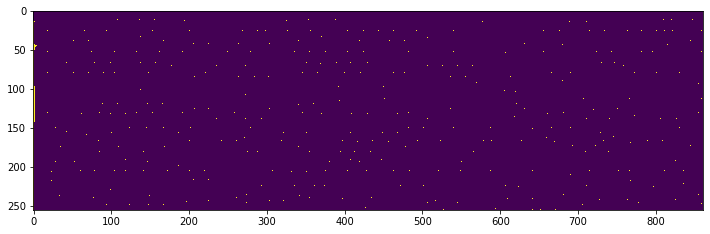

6545
mp3/iamthemorning.mp3


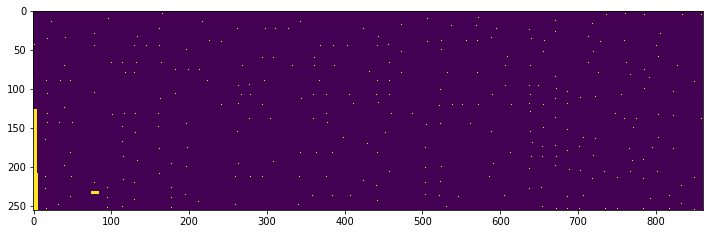

5128
mp3/Little Big.mp3


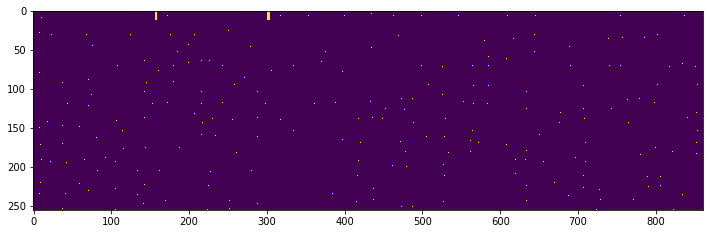

3459
mp3/request.mp3


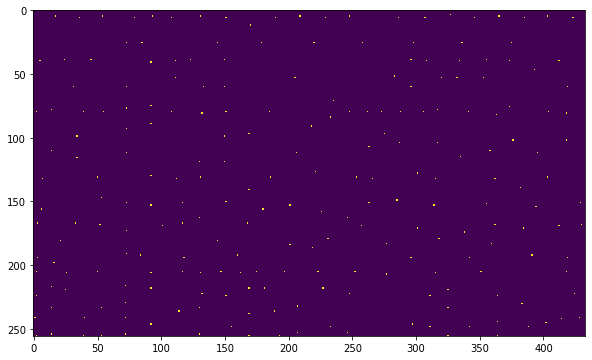

231


In [4]:
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
neighborhood_size = 20

# sec/sample - constant for all files
wav = dataset["mp3/ACDC.mp3"]
time_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
print("Time resolution:", time_resolution)

def form_constellation(name, wav, sample_rate, time_resolution):
    S = librosa.feature.melspectrogram(wav, sr=sample_rate, n_mels=256, fmax=4000)
    S = librosa.power_to_db(S, ref=np.max)
    # get local maxima
    Sb = maximum_filter(S, neighborhood_size) == S
    
    Sbd, num_objects = ndimage.label(Sb)
    objs = ndimage.find_objects(Sbd)
    points = []
    for dy, dx in objs:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2    
        if (dx.stop - dx.start) * (dy.stop - dy.start) == 1:
            points.append((x_center, y_center))
            
    # 20 seconds
    low = int(0 / time_resolution)
    hi = int(20 / time_resolution)
    print(name)
    plt.figure(figsize=(12,6))
    plt.imshow(Sb[:, low:hi])
    plt.show()
    print(len(points))
    return sorted(points) 
    

constellations = {}
for name, wav in dataset.items():
    constellations[name] = form_constellation(name, wav, sample_rate, time_resolution)

request_constellation = form_constellation(request_audio, request_data, sample_rate, time_resolution)

## Task

### 1. Build index from constellations

In [5]:
import tqdm
print(time_resolution)
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)    # start, end, Hz low, Hz high 

index = {}
request = {}

def build_constellation_index(constellation_collection, target):
    # TODO: build shazam index for a collection of constellations
    # consider some window (target) for every point
    # for every point inside this window make an entry in the index (or update it, if the key exists)
    # keys are triples of the form (f1, f2, dt), values are lists with tuples (t, name)
    result_index = {}   
    for name, values in constellation_collection.items():
        for v in tqdm.tqdm_notebook(values,name,leave=True):
            for match in filter(lambda x : x[0] > v[0]+target[0] and x[0] < v[0]+target[1] and x[1] > target[2] and x[1] < target[3] and v != x ,values):
                #for every point inside this window make an entry in the index (or update it, if the key exists)
                # keys are triples of the form (f1, f2, dt), values are lists with tuples (t, name)
                dt = match[0] - v[0]
                #if dt < 0: print(match[0], v[0])
                key = f'({v[1]},{match[1]},{dt})'
                if key in result_index.keys(): result_index[key].append((v[0],name))
                else : result_index[key] = [(v[0],name)]
    
    return result_index

index = build_constellation_index(constellations, target)
request = build_constellation_index({request_audio:request_constellation}, target)

0.02321972427354941


In [51]:
# r = {}
# for name, values in constellations.items():
#     for v in tqdm.tqdm_notebook(values,name,leave=True):
#         for match in filter(lambda x : x[0] > target[0] and x[0] < target[1] and x[1] > target[2] and x[1] < target[3] and v != x ,values):
#             #for every point inside this window make an entry in the index (or update it, if the key exists)
#             # keys are triples of the form (f1, f2, dt), values are lists with tuples (t, name)
#             dt = match[0] - v[0]
#             key = f'({v[1]},{match[1]},{dt})'
#             if key in r.keys(): r[key].append((v[0],name))
#             else : r[key] = [(v[0],name)]
        

### 2. Compare request track with all audios 

In [28]:
result = {}
for k, k_v in request.items(): #for every audio in request 
    if k in index.keys():
        for m_k, m_v in filter(lambda x : x[0] == k,index.items()):  #find all keys that match request audio in index
            if len(m_v) != 1: 
                for j in m_v :
                    if j[1] not in result.keys():
                        result[j[1]] = [j[0] - i[0] for i in k_v] #calculate time offset
                    else:
                        result[j[1]] += [j[0] - i[0] for i in k_v] #calculate time offset
            else:
                if m_v[0][1] in result.keys():
                    result[m_v[0][1]] += [m_v[0][0] - i[0] for i in k_v] #calculate time offset
                else:
                    result[m_v[0][1]] = [m_v[0][0] - i[0] for i in k_v] #calculate time offset

In [44]:
from collections import Counter
c = Counter(kk['mp3/ACDC.mp3'])
c.most_common()

mp3/ACDC.mp3


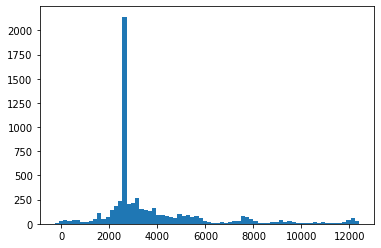

mp3/Little Big.mp3


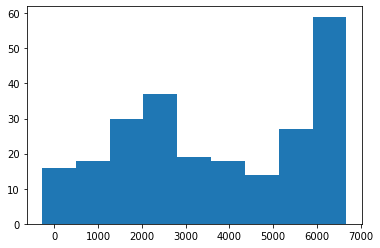

mp3/iamthemorning.mp3


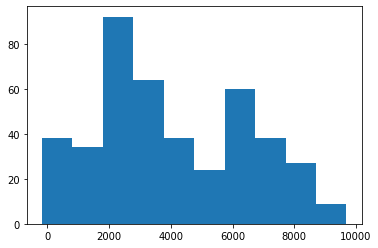

In [51]:
import matplotlib.pyplot as plt
for song in result.keys():
    print(song)
    #w = Counter(result[song])
    #plt.bar(w.keys(), w.values())
    n, bins, patches = plt.hist(x=result[song], bins='auto')
    plt.show()

mp3/ACDC.mp3


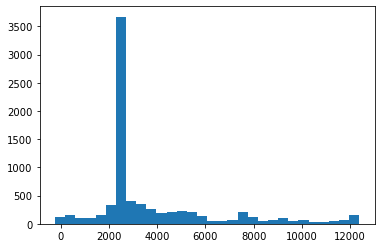

mp3/iamthemorning.mp3


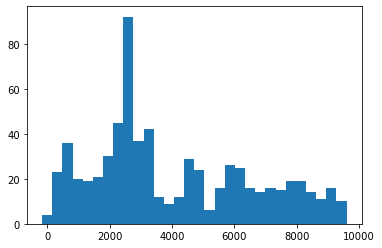

mp3/Little Big.mp3


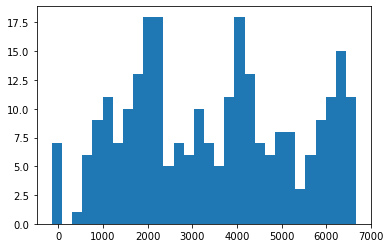

In [7]:
# TODO for every audio find all keys that match request audio keys 
# for every such match calculate time offset (difference between audio and request)
# display counts of matches for every time offset (using histogram, for example)